<a href="https://colab.research.google.com/github/vibferreira/machine_learning_2021_UBS/blob/main/BARBOSA_FERREIRA_Lab_LogReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical lab: Logistic Regression by using the gradient descent algorithm

## Utils

In [ ]:
import os # working directory
import pandas as pd # data analysis
from scipy import stats # descriptive statistics
import matplotlib.pyplot as plt # graphics
import numpy as np # maths
import sklearn.preprocessing # data standardisation
from collections import Counter # table frequency
from sklearn.metrics import accuracy_score
import seaborn as sns

from sklearn import datasets # data
from sklearn.linear_model import LogisticRegression, ElasticNet, Ridge # Logistic Regression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV # train and test samples
from sklearn.metrics import confusion_matrix # confusion matrix
from scipy import optimize # optimisation algorithms

## Data

The data relates to a breast cancer clinical study conducted at the University of Winconsin. This is to predict the status of the tumor (malignant=1 or benign=0) from characteristics of cells taken from patients
* radius (mean of distances from center to points on the perimeter)
* texture (standard deviation of gray-scale values)
* perimeter
* area
* ···

Objective: to study the probability of having a malignant tumor depending on certain characteristics

The data was originally published by W.N. Street, W.H. Wolberg and O.L. Mangasarian. Nuclear feature extraction for breast tumor diagnosis. IS&T/SPIE 1993 International Symposium on Electronic Imaging : Science and Technology, volume 1905, pages 861-870, San Jose, CA, 1993.

The practical lab includes the following steps (you must fill in the different notebook cells)
* Import data
* Build the necessary functions: f, cost, gradient then implement the gradient descent algorithm (some functions are identical to those produced in the case of the linear regression)
* Test for the case of simple logistic regression
* Then extend the test to multiple logistic regression
* Return the model coefficients and the values of the cost function for all iterations
* Vary the parameters of the algorithm (initialization, learning rate) and comment.
* Compare with native Python optimization solutions (no exact solution here)

In [ ]:
#-- Data import
breast_cancer = datasets.load_breast_cancer()
print(breast_cancer.DESCR)
#Data Set Characteristics:
#    :Number of Instances: 569
#
#    :Number of Attributes: 30 numeric, predictive attributes and the class
#
#    :Attribute Information:
#        - radius (mean of distances from center to points on the perimeter)
#        - texture (standard deviation of gray-scale values)
#        - perimeter
#        - area
#        - smoothness (local variation in radius lengths)
#        - compactness (perimeter^2 / area - 1.0)
#        - concavity (severity of concave portions of the contour)
#        - concave points (number of concave portions of the contour)
#        - symmetry
#        - fractal dimension ("coastline approximation" - 1)
#
#        The mean, standard error, and "worst" or largest (mean of the three
#        largest values) of these features were computed for each image,
#        resulting in 30 features.  For instance, field 3 is Mean Radius, field
#        13 is Radius SE, field 23 is Worst Radius.
#
#        - class:
#                - WDBC-Malignant
#                - WDBC-Benign

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [ ]:
#-- Descriptive stat
dat=breast_cancer.data
Y=breast_cancer.target
names = breast_cancer.feature_names

#%% Stat descriptives
df=pd.DataFrame(dat)
df_y=pd.DataFrame(Y)
df.columns=names # pour ajouter les noms de colonnes
df['Y'] = df_y

In [ ]:
# Some stats with Counter
Counter(Y) # nb of cases / controls
df.groupby(Y).mean()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Y
0,17.462830,21.604906,115.365377,978.376415,0.102898,0.145188,0.160775,0.087990,0.192909,0.062680,0.609083,1.210915,4.323929,72.672406,0.006780,0.032281,0.041824,0.015060,0.020472,0.004062,21.134811,29.318208,141.370330,1422.286321,0.144845,0.374824,0.450606,0.182237,0.323468,0.091530,0
1,12.146524,17.914762,78.075406,462.790196,0.092478,0.080085,0.046058,0.025717,0.174186,0.062867,0.284082,1.220380,2.000321,21.135148,0.007196,0.021438,0.025997,0.009858,0.020584,0.003636,13.379801,23.515070,87.005938,558.899440,0.124959,0.182673,0.166238,0.074444,0.270246,0.079442,1


In [ ]:
# Retrieving 3 first smallest negative correlactions 
corr = df.corr().sort_values(by=['Y'])[:3]
corr

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Y
worst concave points,0.744214,0.295316,0.771241,0.722017,0.503053,0.815573,0.861323,0.910155,0.430297,0.175325,0.531062,-0.119638,0.554897,0.538166,-0.102007,0.483208,0.440472,0.602450,-0.030413,0.215204,0.787424,0.359755,0.816322,0.747419,0.547691,0.801080,0.855434,1.000000,0.502528,0.511114,-0.793566
worst perimeter,0.965137,0.358040,0.970387,0.959120,0.238853,0.590210,0.729565,0.855923,0.219169,-0.205151,0.719684,-0.102242,0.721031,0.761213,-0.217304,0.260516,0.226680,0.394999,-0.103753,-0.001000,0.993708,0.365098,1.000000,0.977578,0.236775,0.529408,0.618344,0.816322,0.269493,0.138957,-0.782914
mean concave points,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,0.698050,0.021480,0.710650,0.690299,0.027653,0.490424,0.439167,0.615634,0.095351,0.257584,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661,-0.776614


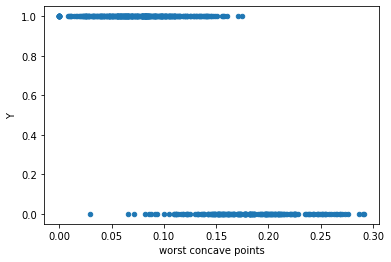

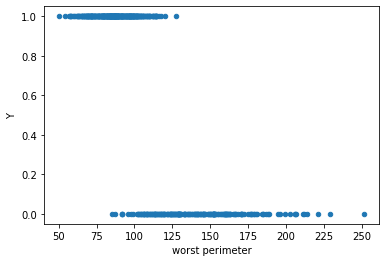

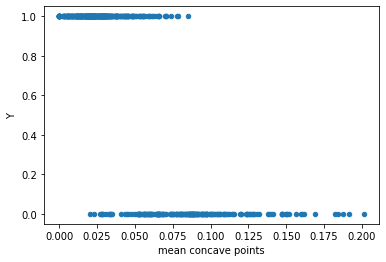

In [ ]:
#-- Plots
for i in corr.index:
    df.plot.scatter(x=i, y='Y')

In [ ]:
#-- Buils Xs and Xm for simple and multiple logistic regresstion
Xs = np.vstack(df[corr.index[0]])
Xm = df[corr.index].to_numpy()

print(Xs.shape, Xm.shape)

(569, 1) (569, 3)


In [ ]:
Xm


array([[2.654e-01, 1.846e+02, 1.471e-01],
       [1.860e-01, 1.588e+02, 7.017e-02],
       [2.430e-01, 1.525e+02, 1.279e-01],
       ...,
       [1.418e-01, 1.267e+02, 5.302e-02],
       [2.650e-01, 1.846e+02, 1.520e-01],
       [0.000e+00, 5.916e+01, 0.000e+00]])

## Logistic regression by using the gradient descent algorithm


In [ ]:
###### -- X standardisation
def standardisation(X:np.array)-> np.array:
  """ 
  X: variable(s) to be standardised 
  Returns np.array with standardized values around the mean center for each variable
  """
  return (X-X.mean(axis=0))/X.std(axis=0,ddof=1)

#-- Test 1 - simple regression
Xs_stand = standardisation(Xs)

#-- Test 2 - multiple regression
Xm_stand = standardisation(Xm)

In [ ]:
#-- Preparing the matrix used for the regression linear when using the gradient descent algorithm (add 1 column)
ones = np.ones((Xs.shape[0],1))

Xm_stand_r = np.hstack((ones, Xm_stand))
Xs_stand_r = np.hstack((ones, Xs_stand))

Xm_stand_r

array([[ 1.        ,  2.2940576 ,  2.30157548,  2.53024886],
       [ 1.        ,  1.08612862,  1.53377643,  0.54766227],
       [ 1.        ,  1.95328166,  1.34629062,  2.03543978],
       ...,
       [ 1.        ,  0.41370467,  0.57849157,  0.10568437],
       [ 1.        ,  2.28797231,  2.30157548,  2.65652826],
       [ 1.        , -1.7435287 , -1.4314754 , -1.26071029]])

In [ ]:
#-- Model
# be careful: X contains X_0 = [1,...,1] + X_j
def f(x:np.array, 
      betas:np.array)->np.array:
  """
  x: np.array, independent variable
  betas: np.array, hyperparameters b0 and b1
  Returns np.array of the predicted values (regression line)
  """
  x=np.dot(x, betas)
  return 1/(1 + np.exp(-x))

#-- Test 1 - simple regression
Xs_y_hat = f(Xs_stand_r,[0.2,0.2])
#-- Test 2 - multiple regression
Xm_y_hat = f(Xm_stand_r, [0.1,0.1,0.1,0.1])
# x = np.linspace(test.min(),test.max(),569)
# plt.plot(x,test)

In [ ]:
Xm_y_hat[:10]

array([0.69266076, 0.6027069 , 0.65328293, 0.60765327, 0.61047797,
       0.56498321, 0.60370224, 0.54995059, 0.58682348, 0.58111438])

In [ ]:
#-- Cost function
def cost(X:np.array,
         y:np.array,
         betas:np.array):
  """
  X: np.array, independent variable
  y: np.array, depedent variable
  betas: np.array, hyperparameters b0 and b1
  Return the mean of the squared residuals
  """

  y_hat=f(X, betas)
  # print(y_hat)
  loss = -np.mean(y*np.log(y_hat) + (1-y)*np.log(1-y_hat)) #how to deal with inf

  return loss

#-- Test 1 - simple regression
print('Simple regression: ', cost(Xs_stand_r,Y, [0.2,0.2]))


#-- Test 2 - multiple regression
print('Multiple regression: ',cost(Xm_stand_r, Y, [0.2,0.2,0.2,0.2]))


Simple regression:  0.7542311892640812
Multiple regression:  0.9382808744844654


In [ ]:
#-- Gradient
def grad(X:np.array, 
         y:np.array, 
         betas:np.array)->np.array:
  """
  X: np.array, independent variable
  y: np.array, depedent variable
  betas: np.array, hyperparameters b0 and b1
  Return np.array of the gradients of the function (derivatives in relation to the intercept and the slope)
  """
  m = X.shape[0]
  return 1/m*np.dot(f(X,betas)-y, X)


#-- Test 1 - simple regression
grad(Xs_stand_r,Y, [0.2,0.2])

#-- Test 2 - multiple regression
grad(Xm_stand_r,Y, [0,0,0,0])

array([-0.12741652,  0.38334594,  0.37820036,  0.37515689])

In [ ]:
#%% Gradient descent algorithm
def grad_descent(betas: np.array, 
                 X:np.array, 
                 y:np.array, 
                 n_interations: int, 
                 learn_rate: float) -> (np.array,int):

  """
  betas: np.array, hyperparameters b0 and b1 (initialisation)
  X: np.array, independent variable
  y: np.array, depedent variable
  n_interations: int, number of interations
  learn_rate: float, the step in which the function learn the optimal parameters
  """               
  beta_array = list()
  cost_array = list()

  for _ in range(n_interations):
    # step size
    betas -= learn_rate * grad(X, y, betas)

    # cost function
    cost_tosave = cost(X, y, betas)

    # check if the diff of two consecutive interations is low
    if len(cost_array) > 2 and (cost_array[-1] - cost_tosave < 0.0000000001):
      break

    # saving list of numpy arrays 
    cost_array.append(cost_tosave)
    beta_array.append(betas.copy()) # copying the betas to solve numpy pointer to the memory issue

  return np.array(beta_array), np.array(cost_array)


In [ ]:
#-- Test 1  - simple reg
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(Xs_stand_r, Y, random_state=0,test_size=0.25)
x_train_m, x_test_m, y_train_m, y_test_m = train_test_split(Xm_stand_r, Y, random_state=0,test_size=0.25)

start = [0,  0]  
n_interations = 20000
new_betas, cost_f= grad_descent(start, x_train_s, y_train_s, n_interations, 0.001)
print('Optimal betas \n \nSingle variable: ', new_betas[-1], 'Least error: ', np.min(cost_f))

#-- Test 2 - multiple reg
start_m = [0.5, 0.5, 0.5 , 0.5] 
new_betas_m, cost_f_m = grad_descent(start_m, x_train_m, y_train_m, n_interations, 0.001)
print('\nMultiple variable: ', new_betas_m[-1], 'Least error: ', np.min(cost_f_m))

Optimal betas 
 
Single variable:  [ 0.72168708 -2.35592088] Least error:  0.25249853849858767

Multiple variable:  [ 0.66526306 -1.27530537 -1.38547895 -1.15371805] Least error:  0.16639475762218875


## Experiment with several initialisations: visualisation of the cost function and parameter values during the iterations

In [ ]:
# simple reg
param = [start,[0.05,0.05],[-0.08,-0.08]]

_,cost_f_2= grad_descent(param[1], x_train_s, y_train_s, n_interations, 0.005)
_,cost_f_3= grad_descent(param[2], x_train_s, y_train_s, n_interations, 0.005)

y_axis_s = [cost_f, cost_f_2, cost_f_3]

# multiple reg 
param_m = [start_m ,[0.03,0.03,0.03,0.03], [-0.5, -0.5, -0.5, -0.5]]

_, cost_f_m_2= grad_descent(param_m[1], x_train_m, y_train_m, 10000, 0.005)
_, cost_f_m_3= grad_descent(param_m[2], x_train_m, y_train_m, 10000, 0.005)

y_axis_m = [cost_f_m, cost_f_m_2, cost_f_m_3]

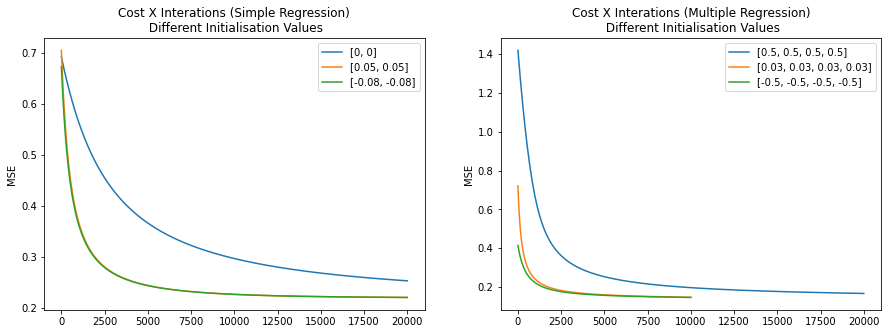

In [ ]:
def plot_comparison(y_axis_s:list, 
                    y_axis_m:list,
                    param_s:list,
                    param_m:list, 
                    x_axis_s=None,
                    x_axis_m=None,
                    legend:str = ''):

    """ Plot a comparison between single and multiple regression """

    #-- Test 1  - simple reg 
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
    ax1.plot(y_axis_s[0], label = f'{param_s[0]}')
    ax1.plot(y_axis_s[1], label = f'{param_s[1]}')
    ax1.plot(y_axis_s[2], label = f'{param_s[2]}')
    ax1.set_title(f'Cost X Interations (Simple Regression)\n {legend}')
    ax1.set_ylabel('MSE')
    ax1.legend()

    #-- Test 2 - multiple reg
    ax2.plot(y_axis_m[0], label = f'{param_m[0]}')
    ax2.plot(y_axis_m[1], label = f'{param_m[1]}')
    ax2.plot(y_axis_m[2], label = f'{param_m[2]}')
    ax2.set_title(f'Cost X Interations (Multiple Regression)\n {legend}')
    ax2.set_ylabel('MSE')
    ax2.legend()

    plt.show()

plot_comparison(y_axis_s, y_axis_m, param, param_m, legend="Different Initialisation Values" )

COMMENTS: 
The results above show that the best init values are represented by the orange and green curves for both simple and multiple logistic regression models, once the error tends closer to 0 after 20k. However, since logistic regression does not have an explicit solution, it is not possible to directly check if the optimal parameters are indeed the best parameters. For simple logistic regression, the model stops running on 20k interactions, not when the error becomes very very, even for the init parameters that performs better, which may indicate the optimal value was still not achieved. On the other hand, for multiple regression, the model stops around 10k interations, indicating the error stabilizes. 

## Experiment with several learning rate: visualisation of the cost function and parameter values during the iterations

In [ ]:
# simple reg
learn = [0.001, 0.0001, 0.00001]

_,cost_f_2_lr = grad_descent(param[0], x_train_s, y_train_s, n_interations, learn[1])
_,cost_f_3_lr = grad_descent(param[0], x_train_s, y_train_s, n_interations, learn[2])

y_axis_s_learn = [cost_f, cost_f_2_lr, cost_f_3_lr]

# multiple reg 

_, cost_f_m_2_lr= grad_descent(param_m[0], x_train_m, y_train_m, n_interations, learn[1])
_, cost_f_m_3_lr= grad_descent(param_m[0], x_train_m, y_train_m, n_interations, learn[2])

y_axis_m_learn = [cost_f_m, cost_f_m_2_lr, cost_f_m_3_lr]

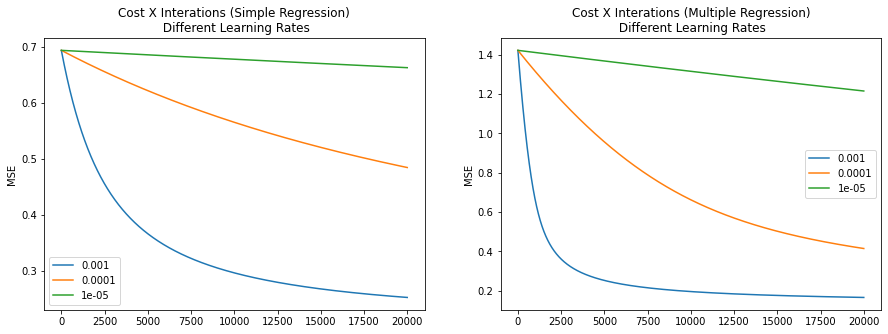

In [ ]:
plot_comparison(y_axis_s_learn, y_axis_m_learn, learn, learn, legend="Different Learning Rates" )

COMMENTS:
The graph above shows the impact of the learning rate on the computation of the cost in each interaction. Lower learning rates requires more time to learn the best parameters. Higher learning rates learn the parameters quicker, but if too big it may overshoot the model parameters. The learning rate 0.001 seens to work fine for both regression model types. 

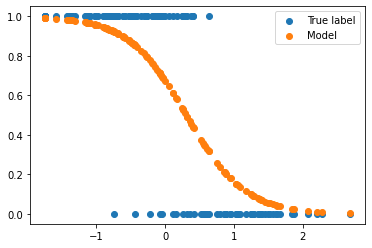

In [ ]:
# Testing the Model with the parameters retrieved from the Gradient Descent
sig = f(x_test_s, new_betas[-1])
binary_pred=np.where(sig < 0.5, 0, 1)

# plt.scatter(x_test_s[:,1:], binary_pred, label = 'Predictions' )
plt.scatter(x_test_s[:,1:], y_test_s, label='True label')
plt.scatter(x_test_s[:,1:],sig, label= 'Model') # why plotting as a line is messing up the visualization???
plt.legend()
plt.show()

In [ ]:
# sig = f(x_test_m, new_betas_m[-1])
# binary_pred=np.where(sig < 0.5, 0, 1)

# plt.scatter(x_test_m[:,3:4], binary_pred, label = 'Predictions' )
# plt.scatter(x_test_m[:,3:4], y_test_s, label='True label')
# plt.scatter(x_test_m[:,3:4],sig, label= 'Model') # why plotting as a line is messing up the visualization???
# plt.legend()
# plt.show()

# Accuracy without Regularisation

Acurracy without regularisation: 90.9090909090909
Simple Model None


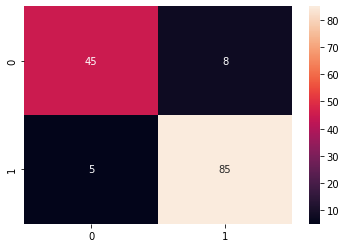

In [ ]:
def acc_without_reg(X, y, betas):
  """ Compute the accuracy without regulatisation """
  y_pred = f(X, betas)
  binary_pred=np.where(y_pred < 0.5, 0, 1)

  print('Acurracy without regularisation:', accuracy_score(y,binary_pred)*100) # change for accuracy score with different init values 

  conf_matrix = confusion_matrix(y, binary_pred)
  sns.heatmap(conf_matrix, annot=True)

print('Simple Model', acc_without_reg(x_test_s,y_test_s,new_betas[-1]))

Acurracy without regularisation: 95.1048951048951
Multiple Model None


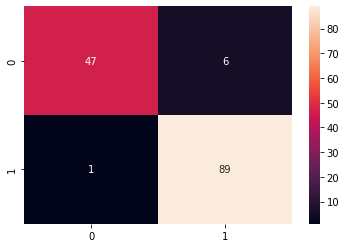

In [ ]:
print('Multiple Model', acc_without_reg(x_test_m, y_test_m,new_betas_m[-1]))

# Regularisation

**Ridge Regression:** Ridge regression is a regularisation tecnique that aims to penalise models tha are too complex, which tends to overfit the data. The strentgh of the penalisation relies on the alpha parameter that is added to the cost function of the model. The code below shows a comparison of accuracy depending on the alpha parameter. When alpha is 0, no penalization is added to the model and therefore the accuracy is the same as the accuracy without regularization. As alpha increases, the stronger the regularisation, which also leads to a slight increase on accuracy. The increase in accuracy may indicate that the model generalises better, therefore, perfoming better with unseen data. However, for Multiple Logistic Regression, changing the did not changed the accuracy, which requires further investigation.

In [ ]:
def alpha_ridge(x_train,
                y_train,
                x_test,
                model_name):
  """" Compute logistic regression model for different values of alpha"""
  alpha = np.linspace(0,99, 5)
  print(f'{model_name}')
  for i in alpha:
    clf = Ridge(alpha=i).fit(x_train,y_train)
    y_pred=clf.predict(x_test)
    binary_pred=np.where(y_pred < 0.5,0,1)
    print(i, '-', accuracy_score(y_test_s, binary_pred))

alpha_ridge(x_train_s,y_train_s,x_test_s, 'Simple Model')
alpha_ridge(x_train_m,y_train_m,x_test_m, '\nMultiple Model')

Simple Model
0.0 - 0.9090909090909091
24.75 - 0.9020979020979021
49.5 - 0.9020979020979021
74.25 - 0.9090909090909091
99.0 - 0.916083916083916

Multiple Model
0.0 - 0.951048951048951
24.75 - 0.951048951048951
49.5 - 0.951048951048951
74.25 - 0.951048951048951
99.0 - 0.951048951048951


**Comparison of regularization techniques**
The outputs below shows the results for running the sklearn's Logistic Regression model considering different regularisation tecnhiques (ridge regression, LASSO and ElasticNet) and not considering any regularisation. In addtion, different regularization strenghts were tested. Differently from the Ridge function, the penalization strength is calculated by the C parameter, which stands for the inverse of the regularisation strength. 
The value of C was set to 0.01 aiming to a stronger penalization.

For simple logistic regression, the highest accuracy was obtained when using ridge and elasticnet, but overall changing the regularisation type did not change considerably the accuracy. For multiple logistic regression, elasticnet showed the best accuracy, with over 2% improvement in comparison to none regularisation. 

In [ ]:
def test_regularizations(x_train,
                         x_test,
                         y_train,
                         y_test,
                         model_name):
  # l2=Ridge, l1=lasso
  penalties = ['l1','l2', 'none']
  print(f'\n{model_name}\n')

  for i in penalties:
    clf = LogisticRegression(penalty=i, solver='saga', C=0.01).fit(x_train,y_train) # C is the inverse of 
    y_pred = clf.predict(x_test)
    print(f'{i}-Betas', clf.coef_)
    print(f'{i}-Accuracy score: ', accuracy_score(y_test,y_pred)*100,'\n')

  regr = ElasticNet(alpha=0.1,random_state=0).fit(x_train,y_train)
  y_pred = regr.predict(x_test)
  print('ElasticNet-Betas', regr.coef_)
  print('ElasticNet-Accuracy score: ', accuracy_score(y_test,np.where(y_pred<0.5,0,1))*100)


test_regularizations(x_train_s,x_test_s,y_train_s,y_test_s,'Simple model')
test_regularizations(x_train_m,x_test_m,y_train_m,y_test_m,'Multiple model')


Simple model

l1-Betas [[ 0.         -0.66770166]]
l1-Accuracy score:  86.7132867132867 

l2-Betas [[ 9.05101566e-06 -8.53201695e-01]]
l2-Accuracy score:  88.11188811188812 

none-Betas [[ 0.57392836 -4.09452615]]
none-Accuracy score:  90.20979020979021 

ElasticNet-Betas [ 0.        -0.3194898]
ElasticNet-Accuracy score:  90.9090909090909

Multiple model

l1-Betas [[ 0.         -0.45442121 -0.2627868   0.        ]]
l1-Accuracy score:  84.61538461538461 

l2-Betas [[-1.00183671e-05 -5.35230176e-01 -5.30532447e-01 -4.90426579e-01]]
l2-Accuracy score:  93.00699300699301 

none-Betas [[ 0.38971252 -2.09465711 -4.11231527 -0.92926694]]
none-Accuracy score:  93.00699300699301 

ElasticNet-Betas [ 0.         -0.16555983 -0.13753655 -0.05491519]
ElasticNet-Accuracy score:  95.1048951048951


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


**Comparison of regularization techniques:** In the previous approaches, the values for the penalization parameter were suggested ramdonly. In order to make a more precise decision on what value of C/alpha to use, cross validation can be used. The GridSearchCV on sklearn package does a cross validated search among all suggested C and regularisation types and returns the best parameters. Then the best parameters find on Grid Search CV were used to computed the cross_val_score for each tested value of C. 


In [ ]:
def cross_val_acc(X,y, model_name):
  x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0,test_size=0.25)

  c_values = np.linspace(0.0001, 1, 10)
  # penalties=['l1','l2']
  hyper = dict(penalty=penalties[:1], C=c_values)

  # Cross validated Grid Search / Finding the best model estimator 
  logistic_model = LogisticRegression(solver='saga')
  clf_cross = GridSearchCV(logistic_model, hyper, cv=10)
  model = clf_cross.fit(x_train, y_train)
  op_model = model.best_estimator_.get_params()

  # Cross validation
  kfold = KFold(n_splits=5)
  l_model = LogisticRegression(C=op_model['C'], penalty=op_model['penalty'], solver='saga')
  acc = cross_val_score(l_model, X, y, cv=kfold).mean()*100
  print(f'{model_name} - Mean accuracy cross validation:', acc)

In [ ]:
cross_val_acc(Xs_stand_r,Y, 'Simple Model')
cross_val_acc(Xm_stand_r,Y, 'Multiple Model')

NameError: ignored